In [1]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
from time import time

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Algorithms / estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA

# Process
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

# Corpus
from documentModel import DocumentModel as DM
from export_results import *

In [2]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


## Showing features in a smaller dimensional space

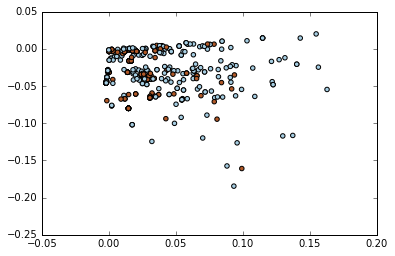

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
extractor = CountVectorizer()
X_t = extractor.fit_transform(X)
X_t_r = SparsePCA(n_components=2).fit_transform(X_t.toarray())
plt.scatter(X_t_r[:, 0], X_t_r[:,1], c = y, cmap=plt.cm.Paired)

In [27]:
extractor = CountVectorizer()
X_t = extractor.fit_transform(X)
X_t_r = SparsePCA(n_components=3).fit_transform(X_t.toarray())

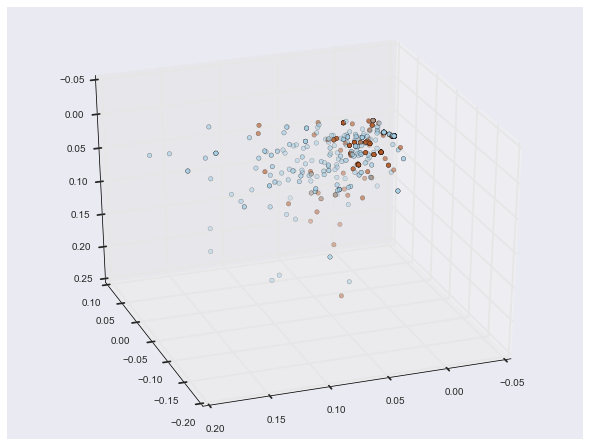

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8,6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_t_r[:,0], X_t_r[:,1], X_t_r[:,2], c = y, cmap = plt.cm.Paired)

In [ ]:
def experiment(mode, X, X_t, y, y_t, model, extractor):
    extractor[1].fit(X)
    model[1].fit(extractor[1].transform(X), y)
    pre_rec = precision_recall_fscore_support(\
                            model[1].predict(extractor[1].transform(X_t)), y_t, pos_label=1)
    cross_validation = StratifiedKFold(y, n_folds=10, shuffle=True)
    
    precisions = cross_val_score(model[1], extractor[1].transform(X), y, cv=cross_validation, scoring='precision')
    recalls = cross_val_score(model[1], extractor[1].transform(X), y, cv=cross_validation, scoring='recall')
    print(mode, extractor[0], model[0])
    print(np.average(precisions), np.std(precisions))
    print(np.average(recalls), np.std(recalls))
    write_result(mode, extractor[0], model[0], pre_rec[0][0], pre_rec[1][0])


In [ ]:
# Classification and ROC analysis
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)

X, y = fito_dataset["data"], fito_dataset["target"]
X_trans = extractor.transform(X)

models = [("Decision Tree", DecisionTreeClassifier()), 
          ("Random Forest", RandomForestClassifier()),
          ("Naive Bayes", MultinomialNB())]

plt.figure(figsize=(12,8))
plt.plot([0,1], [0,1], '--', color=(0.6,0.6,0.6), label='luck')

for model in models:
    mean_precision = 0.0
    mean_recall = np.linspace(0,1,100)
    for i, (train, test) in enumerate(sss):
        probas_ = model[1].fit(X_trans[train], y[train]).predict_proba(X_trans[test])
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1], pos_label=1)
        mean_precision += interp(mean_recall, recall, )
    mean_precision /= len(sss)
    mean_precision[-1] = 1.0
    plt.plot(mean_recall, mean_precision, label='%s' % model[0], lw = 2)
        
plt.ylim([-0.01, 1.01])
plt.xlim([-0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

strategies = ["stratified", "most_frequent", "uniform" , "constant"] # "prior"

extractor = TfidfVectorizer()
extractor.fit(X)

random_state = np.random.RandomState(2016)
for strategy in strategies:
    if strategy == "constant":
        dummy = DummyClassifier(strategy = strategy, random_state = random_state, constant=1)
    else:
        dummy = DummyClassifier(strategy = strategy, random_state = random_state)
    dummy.fit(extractor.transform(X), y)
    print(recall_score(dummy.predict(extractor.transform(X)), y))

In [3]:
sss = StratifiedShuffleSplit(y, n_iter = 30, test_size=0.2, random_state=0)
extractor = TfidfVectorizer(use_idf=True, stop_words=stop_words)
models = [("Decision Tree", DecisionTreeClassifier), 
          ("Random Forest", RandomForestClassifier),
          ("Naive Bayes", MultinomialNB),
          ("Linear SVC", SVC)]
costs = range(2,30)
axis_costs = range(1,29)

def normalize(num):
    max = 100
    min = 1
    
    return (num - min)/(max - min)

false_negatives_avg = {}
false_positives_std = {}
false_positives_avg = {}
false_negatives_std = {}
false_negatives_avg["Decision Tree"] = []
false_negatives_avg["Random Forest"] = []
false_negatives_avg["Naive Bayes"] = []
false_negatives_avg["Linear SVC"] = []

false_positives_avg["Decision Tree"] = []
false_positives_avg["Random Forest"] = []
false_positives_avg["Naive Bayes"] = []
false_positives_avg["Linear SVC"] = []

false_negatives_std["Decision Tree"] = []
false_negatives_std["Random Forest"] = []
false_negatives_std["Naive Bayes"] = []
false_negatives_std["Linear SVC"] = []

false_positives_std["Decision Tree"] = []
false_positives_std["Random Forest"] = []
false_positives_std["Naive Bayes"] = []
false_positives_std["Linear SVC"] = []

true_positives_avg = {}
true_positives_std = {}
true_positives_avg["Decision Tree"] = []
true_positives_avg["Random Forest"] = []
true_positives_avg["Naive Bayes"] = []
true_positives_avg["Linear SVC"] = []

true_positives_std["Decision Tree"] = []
true_positives_std["Random Forest"] = []
true_positives_std["Naive Bayes"] = []
true_positives_std["Linear SVC"] = []

precision_avg = {}
recall_avg = {}
precision_std = {}
recall_std = {}
precision_avg["Decision Tree"] = []
precision_avg["Random Forest"] = []
precision_avg["Naive Bayes"] = []
precision_avg["Linear SVC"] = []

precision_std["Decision Tree"] = []
precision_std["Random Forest"] = []
precision_std["Naive Bayes"] = []
precision_std["Linear SVC"] = []

recall_avg["Decision Tree"] = []
recall_avg["Random Forest"] = []
recall_avg["Naive Bayes"] = []
recall_avg["Linear SVC"] = []


recall_std["Decision Tree"] = []
recall_std["Random Forest"] = []
recall_std["Naive Bayes"] = []
recall_std["Linear SVC"] = []

for estimator in models:
    for cost in costs:
        if estimator[0] == "Naive Bayes":
            model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        elif estimator[0] == "Random Forest":
            model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
        else:
            model = estimator[1](class_weight={1:cost-1})
        extractor.fit(X)
        false_positives = []
        false_negatives = []
        true_positives = []
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = extractor.transform(X)[train_index], extractor.transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            cm = confusion_matrix(y_test, model.predict(X_test))
            #print(cm)
            #print(classification_report(y_test, model.predict(X_test)))
            #print(precision_score(y_test, model.predict(X_test), pos_label=1))
            #print(recall_score(y_test, model.predict(X_test), pos_label=1))
            #print(cm[0][1]/collections.Counter(y_test)[1])
            true_positives.append(cm[1][1]/collections.Counter(y_test)[1])
            false_positives.append(cm[0][1]/collections.Counter(y_test)[0])
            false_negatives.append(cm[1][0]/collections.Counter(y_test)[1])
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
            
        false_positives_avg[estimator[0]].append(np.average(false_positives))
        false_positives_std[estimator[0]].append(np.std(false_positives))
        false_negatives_avg[estimator[0]].append(np.average(false_negatives))
        false_negatives_std[estimator[0]].append(np.std(false_negatives))
        true_positives_avg[estimator[0]].append(np.average(true_positives))
        true_positives_std[estimator[0]].append(np.std(true_positives))
        
        precision_avg[estimator[0]].append(np.average(precisions))
        precision_std[estimator[0]].append(np.std(precisions))
        recall_avg[estimator[0]].append(np.average(recalls))
        recall_std[estimator[0]].append(np.std(recalls))

In [ ]:
# Classification and ROC analysis
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)

X, y = fito_dataset["data"], fito_dataset["target"]
X_trans = extractor.transform(X)

models = [("Decision Tree", DecisionTreeClassifier(class_weight={1:50})), 
          ("Random Forest", RandomForestClassifier()),
          ("Naive Bayes", MultinomialNB()),
          ("Linear SVC", SVC(kernel="linear", probability=True))]

plt.figure(figsize=(12,8))
plt.plot([0,1], [0,1], '--', color=(0.6,0.6,0.6), label='luck')

for model in models:
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    for i, (train, test) in enumerate(sss):
        probas_ = model[1].fit(X_trans[train], y[train]).predict_proba(X_trans[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        roc_auc = auc(fpr, tpr)
        #plt.plot(fpr, tpr, lw =1, label = 'ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(sss)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label='%s (area = %0.2f)' % (model[0], mean_auc), lw = 2)
        
plt.ylim([0.4, 1.01])
plt.xlim([0.0, 1.01])
plt.xlabel('False Positive Rate (1-Specifity)')
plt.ylabel('True Positive Rate (Sensivity or Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

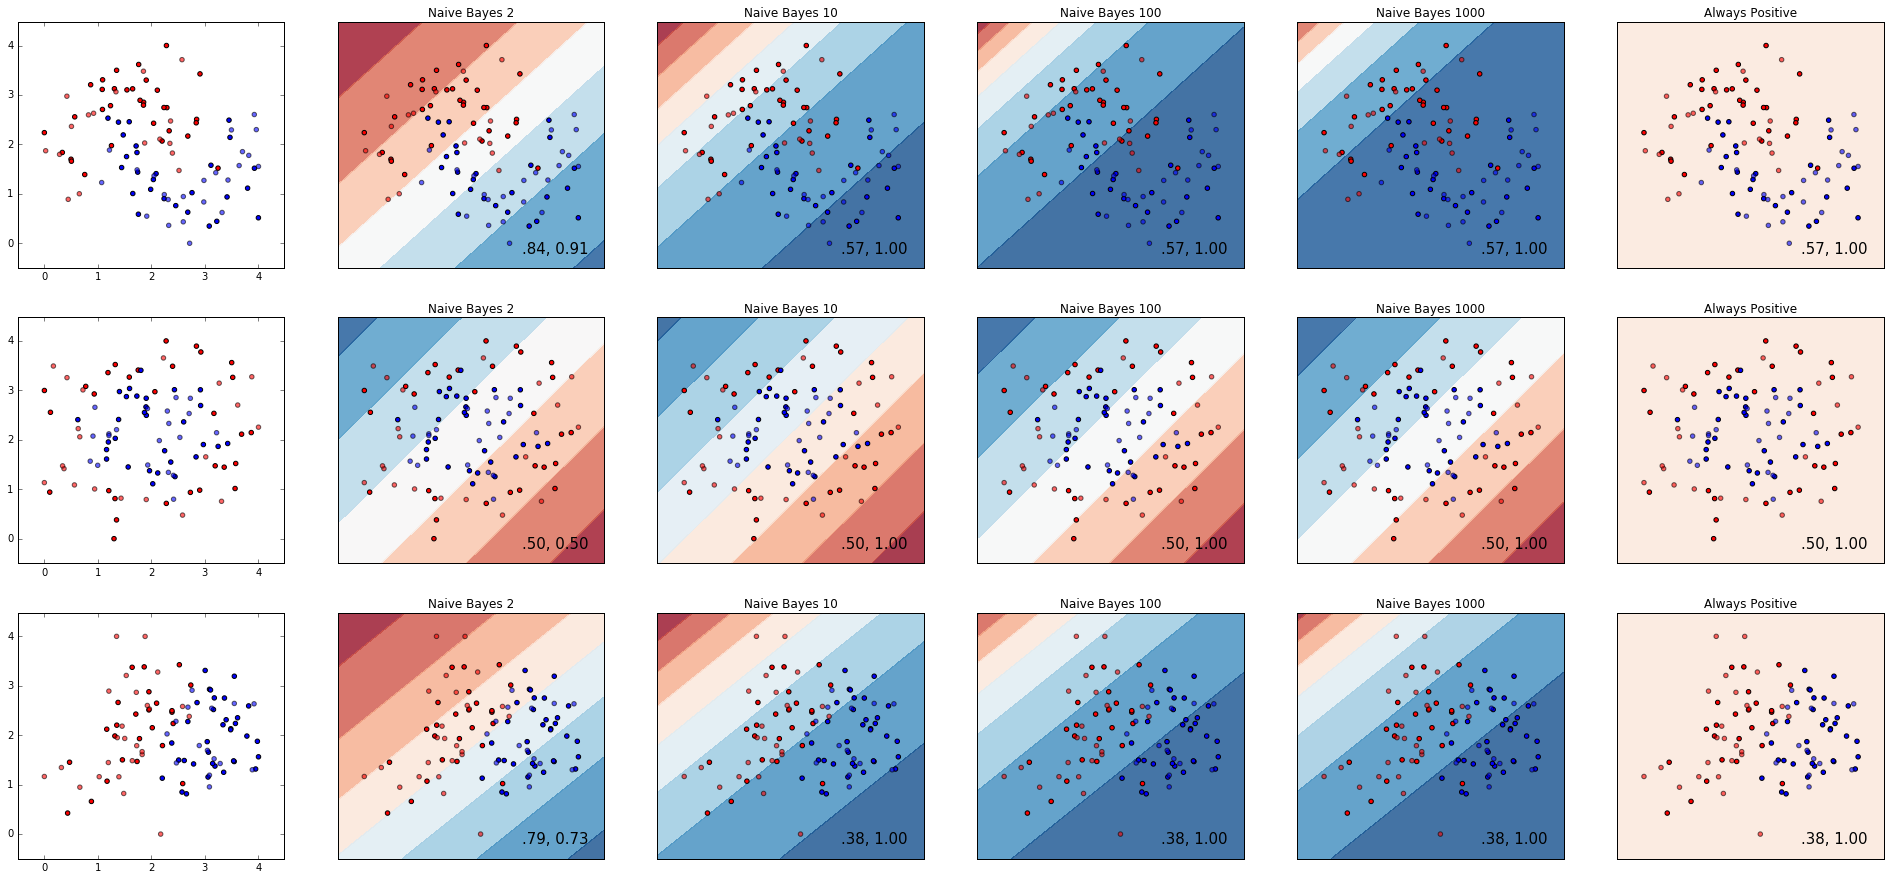

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import recall_score, precision_score
import warnings
warnings.filterwarnings("ignore")


h = .02  # step size in the mesh

names = []
classifiers = []

for cost in [2, 10, 100, 1000]:
    names.append("Naive Bayes " + str(cost))
    classifiers.append(MultinomialNB(class_prior = [1/cost, (cost-1)/cost]))
    
    
names.append("Always Positive")
classifiers.append(DummyClassifier(strategy='constant', constant=1))

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]


figure = plt.figure(figsize=(27, 15))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = MinMaxScaler(feature_range=(0, 4)).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    i += 1


    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        recall = recall_score(y_test, clf.predict(X_test))
        precision = precision_score(y_test, clf.predict(X_test))

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f, %.2f' % (precision,recall)).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

array([[-0.50184568,  2.52297524],
       [ 1.93642326,  1.54470078],
       [ 1.58361081,  1.93695189],
       ..., 
       [ 2.38414263,  1.15787396],
       [ 0.67726879, -0.23036046],
       [-0.0150344 ,  2.70989113]])

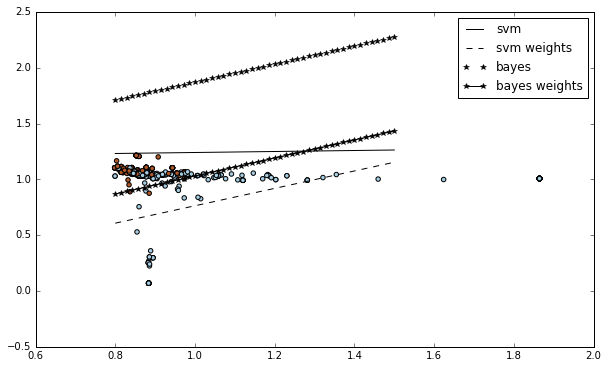

In [9]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer


extractor = TfidfVectorizer()
extractor.fit(X)
pca = PCA(n_components = 2)
X_t = extractor.transform(X)
X_t_r = pca.fit_transform(X_t.toarray())
X_t_r = X_t_r + 1

clf = svm.SVC(kernel = 'linear', C = 1.0)
clf.fit(X_t_r, y)
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0.8, 1.5)
yy = a * xx -clf.intercept_[0]/ w[1]

clf = svm.SVC(kernel = 'linear', C = 1.0, class_weight={1:5})
clf.fit(X_t_r,y)
w = clf.coef_[0]
a = -w[0] / w[1]
yy_w = a * xx - clf.intercept_[0]/w[1]

clf = MultinomialNB()
clf.fit(X_t_r, y)
w = clf.coef_[0]
yy_b = -w[0] * xx - clf.intercept_[0]

clf = MultinomialNB(class_prior=[(4/5)/5, 4/5])
clf.fit(X_t_r, y)
w = clf.coef_[0]
yy_bw = -w[0] * xx - clf.intercept_[0]

plt.figure(figsize=(10,6))
plt.scatter(X_t_r[:,0], X_t_r[:,1], c = y, cmap = plt.cm.Paired)
plt.plot(xx, yy, 'k-', label="svm")
plt.plot(xx, yy_w, 'k--', label="svm weights")
plt.plot(xx, yy_b, 'k*', label="bayes")
plt.plot(xx, yy_bw, 'k*-', label="bayes weights")
plt.legend(loc='best')

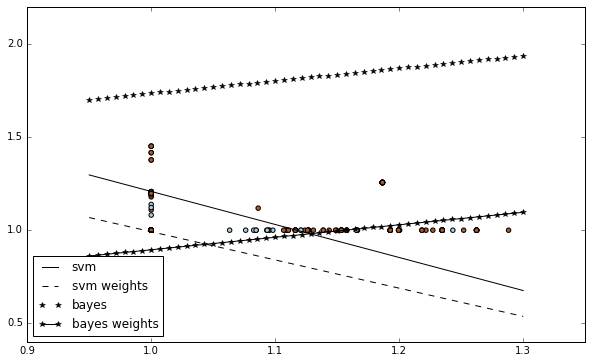

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn import svm

sel = SelectKBest(k = 2)
X_t = extractor.transform(X)
X_t_r = sel.fit_transform(X_t.toarray(),y)
X_t_r = X_t_r + 1

xx = np.linspace(0.95, 1.3)

clf = svm.SVC(kernel = 'linear', C = 1.0)
clf.fit(X_t_r, y)
w = clf.coef_[0]
a = -w[0] / w[1]
yy = a * xx -clf.intercept_[0]/ w[1]

clf = svm.SVC(kernel = 'linear', C = 1.0, class_weight={1:5})
clf.fit(X_t_r,y)
w = clf.coef_[0]
a = -w[0] / w[1]
yy_w = a * xx - clf.intercept_[0]/w[1]

clf = MultinomialNB()
clf.fit(X_t_r, y)
w = clf.coef_[0]
yy_b = -w[0] * xx - clf.intercept_[0]

clf = MultinomialNB(class_prior=[(4/5)/5, 4/5])
clf.fit(X_t_r, y)
w = clf.coef_[0]
yy_bw = -w[0] * xx - clf.intercept_[0]

plt.figure(figsize=(10,6))
plt.scatter(X_t_r[:,0], X_t_r[:,1], c = y, cmap = plt.cm.Paired)
plt.plot(xx, yy, 'k-', label="svm")
plt.plot(xx, yy_w, 'k--', label="svm weights")
plt.plot(xx, yy_b, 'k*', label="bayes")
plt.plot(xx, yy_bw, 'k*-', label="bayes weights")
plt.legend(loc='best')

svm
             precision    recall  f1-score   support

          0       0.81      0.98      0.89       336
          1       0.94      0.58      0.71       177

avg / total       0.86      0.84      0.83       513


weighted svm
             precision    recall  f1-score   support

          0       0.88      0.95      0.91       336
          1       0.88      0.75      0.81       177

avg / total       0.88      0.88      0.87       513


bayes
             precision    recall  f1-score   support

          0       0.65      1.00      0.79       336
          1       0.00      0.00      0.00       177

avg / total       0.43      0.65      0.52       513


weighted bayes
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       336
          1       0.35      1.00      0.51       177

avg / total       0.12      0.35      0.18       513




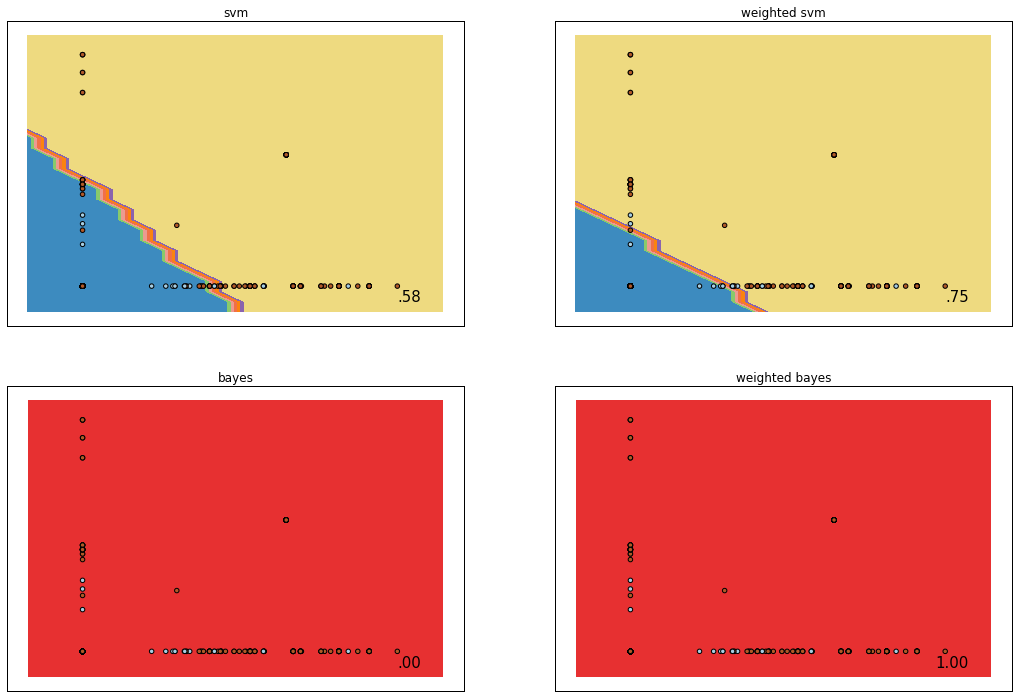

In [53]:
from sklearn.feature_selection import SelectKBest
from sklearn import svm
from sklearn.metrics import *

extractor = TfidfVectorizer()
extractor.fit(X)

step = .02
sel = SelectKBest(k = 2)
X_t = extractor.transform(X)
X_t_r = sel.fit_transform(X_t.toarray(),y)

x_min, x_max = X_t_r[:, 0].min() - 0.05, X_t_r[:, 0].max() + 0.05
y_min, y_max = X_t_r[:, 1].min() - 0.05, X_t_r[:, 1].max() + 0.05

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), 
                     np.arange(y_min, y_max, step))

names = ["svm", "weighted svm", "bayes", "weighted bayes"]
models = [
    svm.SVC(kernel='linear', C = 1.0),
    svm.SVC(kernel = 'linear', C = 1.0, class_weight={1:3}),
    MultinomialNB(),
    MultinomialNB(class_prior=[1, 7])
]

i = 1

plt.figure(figsize=(18,12))
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

for name, model in zip(names, models):
    model.fit(X_t_r, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.subplot(2,2,i)
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, c = y)
    plt.scatter(X_t_r[:, 0], X_t_r[:, 1] , c = y, cmap = plt.cm.Paired, s = 20)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')
    recall = recall_score(y, model.predict(X_t_r))
    print(name)
    print(classification_report(y, model.predict(X_t_r)))
    print("")
    plt.text(xx.max() - .02, yy.min() + .02, ('%.2f' % recall).lstrip('0'),
                size=15, horizontalalignment='right')
    plt.title(name)
    i += 1

plt.show()

svm
             precision    recall  f1-score   support

          0       0.65      1.00      0.79       336
          1       0.00      0.00      0.00       177

avg / total       0.43      0.65      0.52       513


weighted svm
             precision    recall  f1-score   support

          0       1.00      0.25      0.40       336
          1       0.41      1.00      0.59       177

avg / total       0.80      0.51      0.47       513


[0 0 0 ..., 0 0 0]
bayes
             precision    recall  f1-score   support

          0       0.65      1.00      0.79       336
          1       0.00      0.00      0.00       177

avg / total       0.43      0.65      0.52       513


weighted bayes
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       336
          1       0.35      1.00      0.51       177

avg / total       0.12      0.35      0.18       513




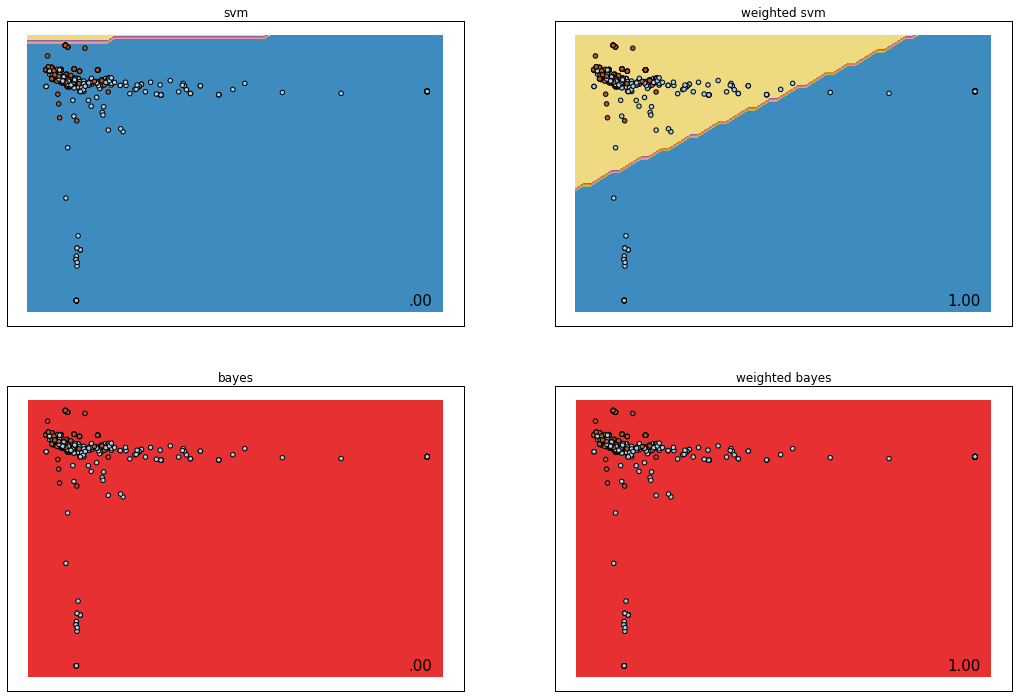

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer


extractor = TfidfVectorizer()
extractor.fit(X)
pca = PCA(n_components = 2)
X_t = extractor.transform(X)
X_t_r = pca.fit_transform(X_t.toarray()) + 1


x_min, x_max = X_t_r[:, 0].min() - 0.05, X_t_r[:, 0].max() + 0.05
y_min, y_max = X_t_r[:, 1].min() - 0.05, X_t_r[:, 1].max() + 0.05

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), 
                     np.arange(y_min, y_max, step))

names = ["svm", "weighted svm", "bayes", "weighted bayes"]
models = [
    svm.SVC(kernel='linear', C = 1.0),
    svm.SVC(kernel = 'linear', C = 1.0, class_weight={1:7}),
    MultinomialNB(),
    MultinomialNB(class_prior=[1, 7])
]

i = 1

plt.figure(figsize=(18,12))
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

for name, model in zip(names, models):
    model.fit(X_t_r, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    if name == "bayes":
        print(Z)
    Z = Z.reshape(xx.shape)
    plt.subplot(2,2,i)
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, c = y)
    plt.scatter(X_t_r[:, 0], X_t_r[:, 1] , c = y, cmap = plt.cm.Paired, s = 20)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')
    plt.title(name)
    print(name)
    print(classification_report(y, model.predict(X_t_r)))
    print("")
    recall = recall_score(y, model.predict(X_t_r))
    plt.text(xx.max() - .03, yy.min() + .03, ('%.2f' % recall).lstrip('0'),
                size=15, horizontalalignment='right')
    i += 1

plt.show()

## Searching for best threshold

In [ ]:
probas_ = model[1].fit(X_trans[train], y[train]).predict_proba(X_trans[test])
fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
print(fpr)
print(tpr)
print(thresholds)

def best_threshold(cfp, cfn, fprs, tprs, thresholds):
    best_cost = 10000
    best_threshold = 1.0
    for fpr, tpr, threshold in (zip(fprs, tprs, thresholds)):
        cost = cfp * fpr + cfn * (1-tpr)
        print(cost)
        if cost < best_cost:
            print("OK")
            print(cost, cfp, fpr, cfn, (1-tpr))
            best_cost = cost
            best_threshold = threshold

    return best_threshold

print()
bs = best_threshold(10000, 1, fpr, tpr, thresholds) 
print("bs", bs)
print()
bs = best_threshold(1, 10000, fpr, tpr, thresholds) 
print("bs", bs)

## Alternative ROC Implementation

In [94]:
def convex_hull(tpr, fpr):
    tp_max = 0
    fp_max = 0
    convex_tpr = []
    convex_fpr = []
    for tp, fp in zip(tpr,fpr):
        if tp > tp_max and fp > fp_max:
            tp_max = tp
            fp_max = fp
        
        convex_tpr.append(tp_max)
        convex_fpr.append(fp_max)
            
    return convex_tpr, convex_fpr

In [95]:
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)
extractor = TfidfVectorizer(use_idf=True, stop_words=stop_words)

costs = range(2,30)
axis_costs = range(1,29)

estimators = [("nb", MultinomialNB), ("dt", DecisionTreeClassifier), 
                  ("rf", RandomForestClassifier)]

false_positives = {}
true_positives = {}
false_positives["dt"] = []
true_positives["dt"] = []
false_positives["nb"] = []
true_positives["nb"] = []
false_positives["rf"] = []
true_positives["rf"] = []

In [96]:
for estimator in estimators:
    for cost in costs:
        if estimator[0] == "nb":
            model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        elif estimator[0] == "rf":
            model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
        else:
            model = estimator[1](class_weight={1:cost-1})
        extractor.fit(X)
        fps = []
        tps = []
        for train_index, test_index in sss:
            X_train, X_test = extractor.transform(X)[train_index], extractor.transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            cm = confusion_matrix(y_test, model.predict(X_test))
            tps.append(cm[1][1]/collections.Counter(y_test)[1])
            fps.append(cm[0][1]/collections.Counter(y_test)[0])
        false_positives[estimator[0]].append(np.std(fps))
        true_positives[estimator[0]].append(np.average(tps))

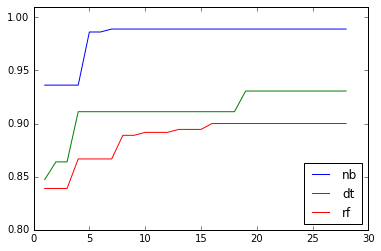

In [103]:
for estimator in estimators:    
    tpr, fpr = convex_hull(true_positives[estimator[0]], \
                       false_positives[estimator[0]])
    plt.plot(axis_costs, tpr, label=estimator[0])
plt.legend(loc="best")
plt.ylim([0.8, 1.01])
plt.show()

### Stemming will increase recall?

In [4]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

In [5]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer(language="spanish")
    
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

In [6]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

extractors = [("Not Stemming", TfidfVectorizer(use_idf=True, stop_words=stop_words)),
              ("Stemming", TfidfVectorizer(tokenizer=LemmaTokenizer(), use_idf=True, stop_words=stop_words))]

models = [("Random Forest", RandomForestClassifier),
          ("Naive Bayes", MultinomialNB),
          ("Linear SVC", SVC)]

costs = np.arange(2,30,5)
axis_costs = range(1,29)
print()

In [28]:
def init(extractors, models):
    recall_avg = {}
    recall_std = {}
    precision_avg = {}
    precision_std = {}
    names = []
    vocabulary_sizes = {}
    for model in models:
        for extractor in extractors:
            name = model[0] + "_" + extractor[0]
            recall_avg[name] = []
            recall_std[name] = []
            precision_avg[name] = []
            precision_std[name] = []
            names.append(name)
            vocabulary_sizes[extractor[0]] = []
        
    return names, recall_avg, recall_std, precision_avg, precision_std, vocabulary_sizes

In [10]:
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedShuffleSplit(y, n_iter = 5, test_size=0.2, random_state=0)
names, recall_avg, recall_std, precision_avg, \
    precision_std, vocabulary_sizes = init(extractors, models)

i = 0

for estimator in models:
    for extractor in extractors:
        extractor[1].fit(X)
        if i%3 == 0:
            print(extractor[0] + " " + str(len(extractor[1].vocabulary_)))
            vocabulary_sizes[extractor[0]] = len(extractor[1].vocabulary_)
        print(names[i])
        for cost in costs:
            if estimator[0] == "Naive Bayes":
                model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
            elif estimator[0] == "Random Forest":
                model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
            elif estimator[0] == "Linear SVC":
                model = estimator[1](class_weight={1:cost-1}, kernel = "linear")
            else:
                model = estimator[1](class_weight={1:cost-1})
            precisions = []
            recalls = []
            for train_index, test_index in sss:
                X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
            recall_avg[names[i]].append(np.average(recalls))
            recall_std[names[i]].append(np.std(recalls))
            precision_avg[names[i]].append(np.average(precisions))
            precision_std[names[i]].append(np.std(precisions))
        i+=1

Not Stemming 1071
Random Forest_Not Stemming
Random Forest_Stemming
Naive Bayes_Not Stemming
Stemming 880
Naive Bayes_Stemming
Linear SVC_Not Stemming
Linear SVC_Stemming


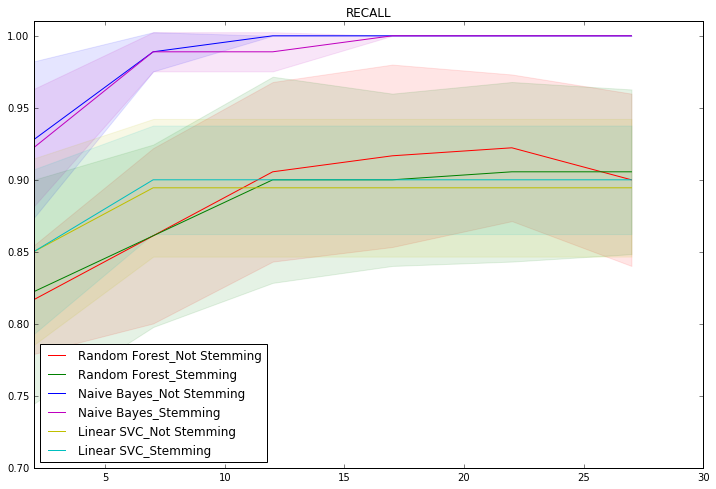

In [12]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.ylim([0.7, 1.05])
plt.xlim([2, 30])
plt.title("RECALL")
for name, color in zip(names, colors):
    plt.plot(costs, recall_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(recall_avg[name]) - recall_std[name], 
                 np.asarray(recall_avg[name]) + recall_std[name], 
                 alpha=0.1, color=color)

plt.ylim([0.7, 1.01])
plt.legend(loc='better')
plt.show()

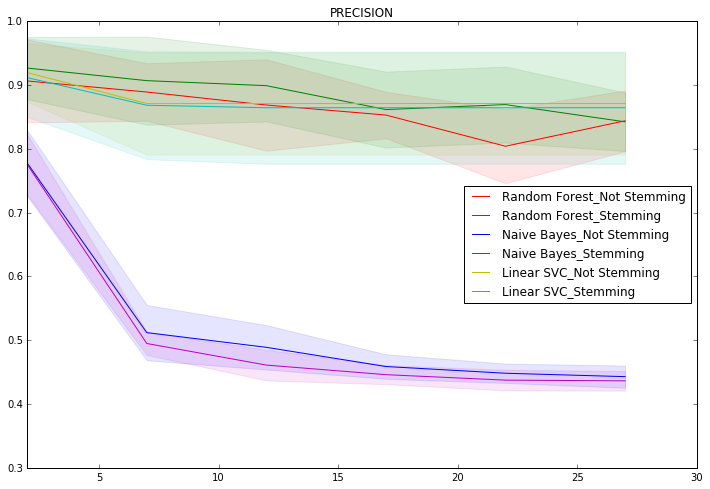

In [15]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.ylim([0.3, 1.])
plt.xlim([2, 30])
plt.title("PRECISION")
for name, color in zip(names, colors):
    plt.plot(costs, precision_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(precision_avg[name]) - precision_std[name], 
                 np.asarray(precision_avg[name]) + precision_std[name], 
                 alpha=0.1, color=color)

plt.legend(loc='better')
plt.show()

### N-grams will increase recall?

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

extractors = [("words", TfidfVectorizer(use_idf=True, stop_words=stop_words)),
              ("n-grams(1..2)", TfidfVectorizer(ngram_range=(1, 2), use_idf=True, stop_words=stop_words)),
             ("n-grams(2..2)", TfidfVectorizer(ngram_range=(2, 2), use_idf=True, stop_words=stop_words))]

models = [("Random Forest", RandomForestClassifier),
          ("Naive Bayes", MultinomialNB),
          ("Linear SVC", SVC)]

costs = np.arange(2,30,5)
axis_costs = range(1,29)
print()

In [20]:
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedShuffleSplit(y, n_iter = 5, test_size=0.2, random_state=0)
names, recall_avg, recall_std, precision_avg, \
    precision_std, vocabulary_sizes = init(extractors, models)

i = 0

for estimator in models:
    for extractor in extractors:
        extractor[1].fit(X)
        print(extractor[0] + " " + str(len(extractor[1].vocabulary_)))
        vocabulary_sizes[extractor[0]] = len(extractor[1].vocabulary_)
        print(names[i])
        for cost in costs:
            if estimator[0] == "Naive Bayes":
                model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
            elif estimator[0] == "Random Forest":
                model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
            elif estimator[0] == "Linear SVC":
                model = estimator[1](class_weight={1:cost-1}, kernel = "linear")
            else:
                model = estimator[1](class_weight={1:cost-1})
            precisions = []
            recalls = []
            for train_index, test_index in sss:
                X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
            recall_avg[names[i]].append(np.average(recalls))
            recall_std[names[i]].append(np.std(recalls))
            precision_avg[names[i]].append(np.average(precisions))
            precision_std[names[i]].append(np.std(precisions))
        i+=1

words 1071
Random Forest_words
n-grams(1..2) 3327
Random Forest_n-grams(1..2)
n-grams(2..2) 2256
Random Forest_n-grams(2..2)
words 1071
Naive Bayes_words
n-grams(1..2) 3327
Naive Bayes_n-grams(1..2)
n-grams(2..2) 2256
Naive Bayes_n-grams(2..2)
words 1071
Linear SVC_words
n-grams(1..2) 3327
Linear SVC_n-grams(1..2)
n-grams(2..2) 2256
Linear SVC_n-grams(2..2)


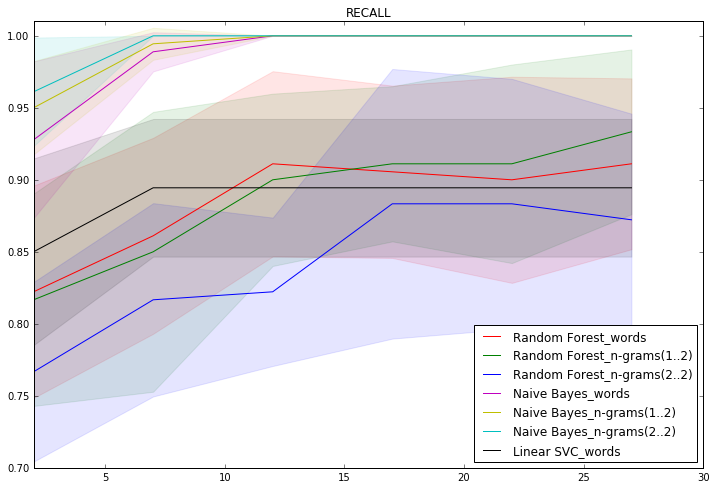

In [23]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.ylim([0.7, 1.05])
plt.xlim([2, 30])
plt.title("RECALL")
for name, color in zip(names, colors):
    plt.plot(costs, recall_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(recall_avg[name]) - recall_std[name], 
                 np.asarray(recall_avg[name]) + recall_std[name], 
                 alpha=0.1, color=color)

plt.ylim([0.7, 1.01])
plt.legend(loc='better')
plt.show()

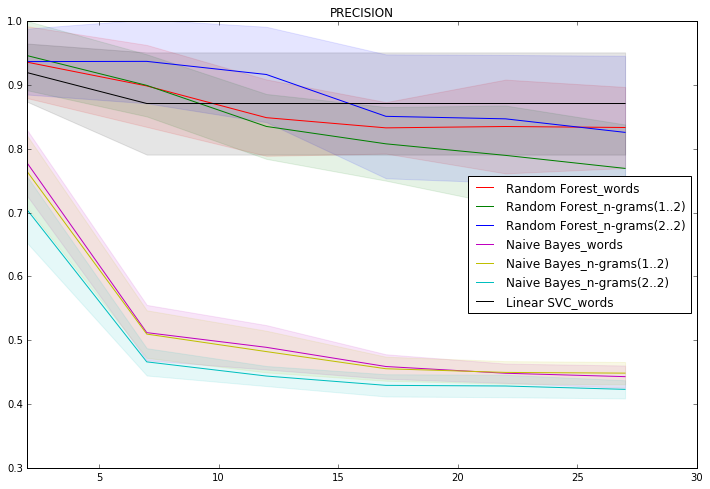

In [19]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.ylim([0.3, 1.])
plt.xlim([2, 30])
plt.title("PRECISION")
for name, color in zip(names, colors):
    plt.plot(costs, precision_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(precision_avg[name]) - precision_std[name], 
                 np.asarray(precision_avg[name]) + precision_std[name], 
                 alpha=0.1, color=color)

plt.legend(loc='better')
plt.show()

### Spanish Tagging

In [14]:
from nltk.corpus import cess_esp as cess
from nltk import UnigramTagger as ut

# Read the corpus into a list, 
# each entry in the list is one sentence.
cess_sents = cess.tagged_sents()

# Train the unigram tagger
uni_tag = ut(cess_sents)

In [15]:
import nltk
sentence = "Evitar que caiga producto en la hoja"

# Tagger reads a list of tokens.
uni_tag.tag(nltk.word_tokenize("Evitar que caiga producto en la hoja"))

[('Evitar', None),
 ('que', 'pr0cn000'),
 ('caiga', 'vmsp3s0'),
 ('producto', 'ncms000'),
 ('en', 'sps00'),
 ('la', 'da0fs0'),
 ('hoja', 'ncfs000')]

In [21]:
tokens = []
for t in uni_tag.tag(nltk.word_tokenize("Evitar que caiga producto en la hoja")):
    token = str(t[0]) + "_" + str(t[1])
    tokens.append(str(t[0]))
    if t[1] != None:
        tokens.append(token)

print(tokens)

['Evitar', 'que', 'que_pr0cn000', 'caiga', 'caiga_vmsp3s0', 'producto', 'producto_ncms000', 'en', 'en_sps00', 'la', 'la_da0fs0', 'hoja', 'hoja_ncfs000']


In [23]:
class POSTokenizer(object):
    
    def __call__(self, doc):
        tokens = []
        for t in uni_tag.tag(nltk.word_tokenize(doc)):
            token = str(t[0]) + "_" + str(t[1])
            tokens.append(str(t[0]))
            if t[1] != None:
                tokens.append(token)
                
        return tokens

In [2]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

extractors = [("Not POS", TfidfVectorizer(use_idf=True, stop_words=stop_words)),
              ("POS Tagging", TfidfVectorizer(tokenizer=POSTokenizer(), use_idf=True, stop_words=stop_words))]

models = [("Random Forest", RandomForestClassifier),
          ("Naive Bayes", MultinomialNB),
          ("Linear SVC", SVC)]

costs = np.arange(2,30,5)
axis_costs = range(1,29)
print()

In [30]:
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedShuffleSplit(y, n_iter = 5, test_size=0.2, random_state=0)
names, recall_avg, recall_std, precision_avg, \
    precision_std, vocabulary_sizes = init(extractors, models)

i = 0

for estimator in models:
    for extractor in extractors:
        extractor[1].fit(X)
        if i%3 == 0:
            print(extractor[0] + " " + str(len(extractor[1].vocabulary_)))
            vocabulary_sizes[extractor[0]] = len(extractor[1].vocabulary_)
        print(names[i])
        for cost in costs:
            if estimator[0] == "Naive Bayes":
                model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
            elif estimator[0] == "Random Forest":
                model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
            elif estimator[0] == "Linear SVC":
                model = estimator[1](class_weight={1:cost-1}, kernel = "linear")
            else:
                model = estimator[1](class_weight={1:cost-1})
            precisions = []
            recalls = []
            for train_index, test_index in sss:
                X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
            recall_avg[names[i]].append(np.average(recalls))
            recall_std[names[i]].append(np.std(recalls))
            precision_avg[names[i]].append(np.average(precisions))
            precision_std[names[i]].append(np.std(precisions))
        i+=1

Not POS 1071
Random Forest_Not POS
Random Forest_POS Tagging
Naive Bayes_Not POS
POS Tagging 1827
Naive Bayes_POS Tagging
Linear SVC_Not POS
Linear SVC_POS Tagging


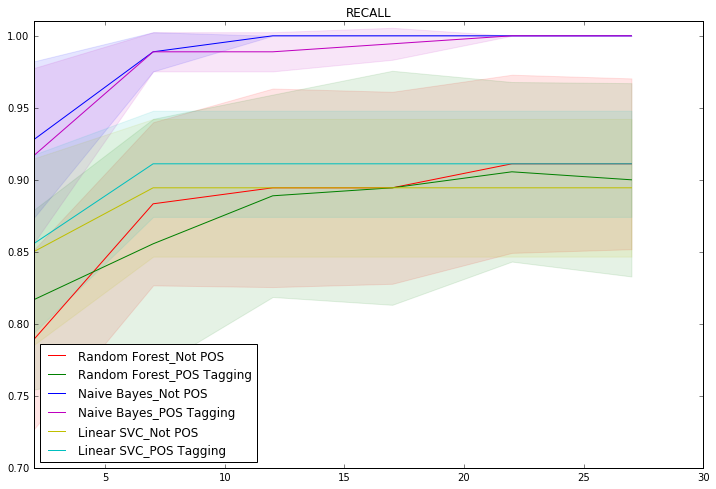

In [31]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.ylim([0.7, 1.05])
plt.xlim([2, 30])
plt.title("RECALL")
for name, color in zip(names, colors):
    plt.plot(costs, recall_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(recall_avg[name]) - recall_std[name], 
                 np.asarray(recall_avg[name]) + recall_std[name], 
                 alpha=0.1, color=color)

plt.ylim([0.7, 1.01])
plt.legend(loc='better')
plt.show()

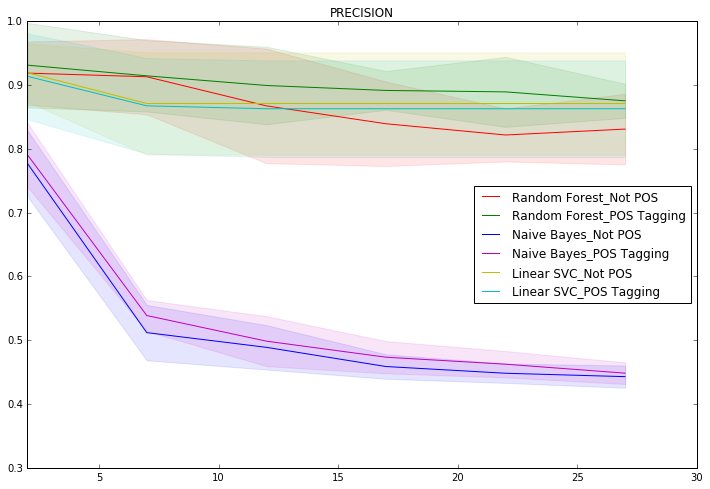

In [32]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.ylim([0.3, 1.])
plt.xlim([2, 30])
plt.title("PRECISION")
for name, color in zip(names, colors):
    plt.plot(costs, precision_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(precision_avg[name]) - precision_std[name], 
                 np.asarray(precision_avg[name]) + precision_std[name], 
                 alpha=0.1, color=color)

plt.legend(loc='better')
plt.show()

## About clustering

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [19]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

extractors = [('idf', TfidfVectorizer(use_idf=True, stop_words=stop_words)), 
              ('tf', TfidfVectorizer(use_idf=False, stop_words=stop_words))]

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


In [20]:
kmeans = KMeans(n_clusters=2)

In [21]:
for extractor in extractors:
    print(extractor[0])
    print(adjusted_rand_score(y, kmeans.fit_predict(extractor[1].fit_transform(X))))
    print(adjusted_mutual_info_score(y, kmeans.fit_predict(extractor[1].fit_transform(X))))

idf
-0.05391947427410922
0.0726919770194
tf
-0.05073437995010963
0.0028619571476


In [26]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

terms = extractor[1].get_feature_names()
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: de
 se
 aplicar
 del
 producto
 no
 por
 etiqueta
 hierbas
 malas
Cluster 1: aplicar
 pulverización
 normal
 no
 sean
 espolvoreo
 del
 cultivos
 conserva
 destinados


## About learning curves

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.learning_curve import learning_curve
import warnings
warnings.filterwarnings('ignore')

In [11]:
def plot_learning_curve(estimator, title, X, y, scoring, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 8)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")

    return plt

In [19]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

extractors = [('idf', TfidfVectorizer(use_idf=True, stop_words=stop_words)), 
              ('tf', TfidfVectorizer(use_idf=False, stop_words=stop_words))]

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)
y = y

print("OK")

Transforming annotated files into training datasets...
OK


In [20]:
titles = ["Naive Bayes (no prior)", "Naive Bayes (prior: 0.9)",
          "Naive Bayes (prior: 0.99)"]

estimators = [MultinomialNB(), MultinomialNB(class_prior=[0.1, 0.9]),
              MultinomialNB(class_prior = [0.01, 0.99]), MultinomialNB(class_prior = [0.001, 0.999])]

scorings = ["precision", "recall"]

cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)

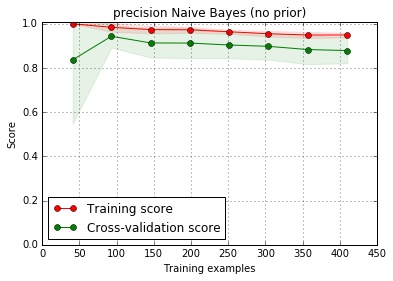

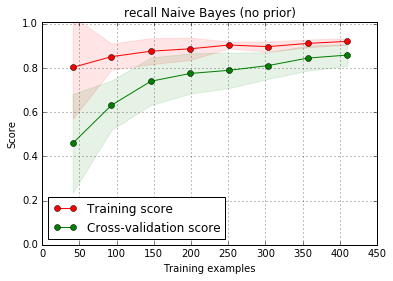

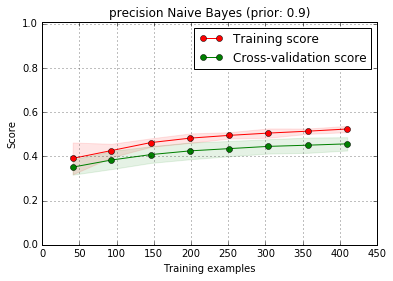

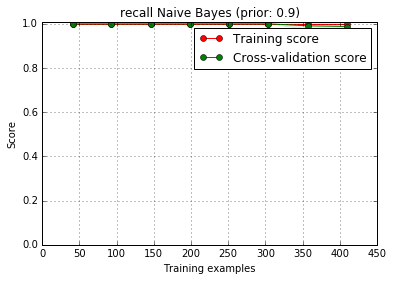

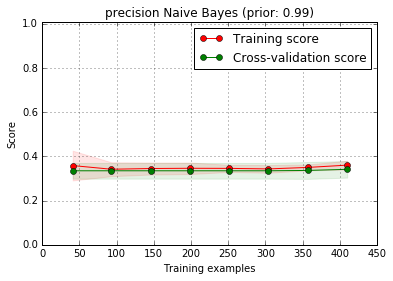

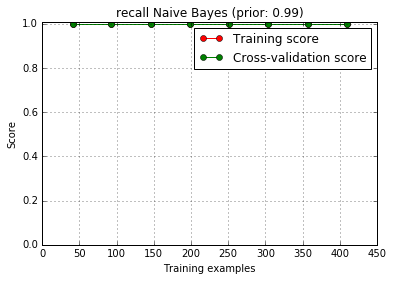

In [21]:
for estimator, title in zip(estimators, titles):
    for scoring in scorings:
        plot_learning_curve(estimator, scoring + " " + title, X, y, scoring,
                                (0.0, 1.01), cv=cv, n_jobs=4)

plt.show()

## About grammars

In [6]:
import nltk
from nltk import PCFG

In [7]:
grammar = PCFG.fromstring("""
S -> NP VP [1.0]
VP -> TV NP [0.4]
VP -> IV [0.3]
VP -> DatV NP NP [0.3]
TV -> 'saw' [1.0]
IV -> 'ate' [1.0]
DatV -> 'gave' [1.0]
NP -> 'telescopes' [0.8]
NP -> 'jack' [0.2]
"""
)

In [12]:
v = nltk.ViterbiParser(grammar)
a = v.parse(nltk.word_tokenize('Jack saw telescopes'))

In [22]:
cp = nltk.ChartParser(grammar)
tokens = nltk.word_tokenize('jack saw telescopes')
for tree in cp.parse(tokens):
    print(tree)

(S (NP jack) (VP (TV saw) (NP telescopes)))


In [23]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")

In [29]:
sent = ['I', 'sht', 'an', 'elephant', 'in', 'my', 'pajamas']
parser = nltk.ChartParser(groucho_grammar)
try:
    for tree in parser.parse(sent):
        print(tree)
except ValueError as ve:
    print("No")

No


In [156]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

extractors = [('idf', TfidfVectorizer(use_idf=True, stop_words=stop_words)), 
              ('tf', TfidfVectorizer(use_idf=False, stop_words=stop_words))]

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

vectorizer = TfidfVectorizer()
X = np.array(X)
#X = vectorizer.fit_transform(X)
y = y

print("OK")

Transforming annotated files into training datasets...
OK


In [165]:
prohibitions = X[np.where(y == 1)]
rules = X

In [180]:
grammar_cl = ProhibitionGrammarClassifier()

In [182]:
grammar_cl.fit(vectorizer.fit_transform(X))
grammar_cl.predict(rules)

[0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,


In [183]:
from sklearn.metrics import *

In [185]:
print(recall_score(y, grammar_cl.predict(X)))
print(precision_score(y, grammar_cl.predict(X)))

0.802259887006
0.830409356725
